# We're going to try fitting a full asymptotic relation to some simulated data

We'll do Gaussian noise cos it makes my life easier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

from utils import *

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def asymptotic(self, n, numax, deltanu, alpha, epsilon):       
        nmax = (numax / deltanu) - epsilon
        over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
        return over * deltanu
    
    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n1, numax, deltanu, alpha, epsilon)
        return f0 + d01
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon)
        return f0 - d02

In [3]:
nmodes = 3
nbase = 18
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

In [11]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.05
epsilon_ = 1.
d01_ = deltanu_/2.
d02_ = 6.

In [12]:
mod = model(ff, n0_, n1_, n2_)

In [13]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]
f0_ = mod.f0(init_f)
f1_ = mod.f1(init_f)
f2_ = mod.f2(init_f)

In [14]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [15]:
mod = model(f, n0_, n1_, n2_)

In [16]:
init_m =[f0_,                         # l0 modes
           f1_,                         # l1 modes
           f2_,                         # l2 modes
           np.ones(len(f0_)) * 2.0,     # l0 widths
           np.ones(len(f1_)) * 2.0,     # l1 widths
           np.ones(len(f2_)) * 2.0,     # l2 widths
           np.sqrt(gaussian(f0_, 0, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l0 heights
           np.sqrt(gaussian(f1_, 1, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l1 heights
           np.sqrt(gaussian(f2_, 2, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l2 heights
           1,       # splitting
           np.pi/4.,                    # inclination angle
           1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

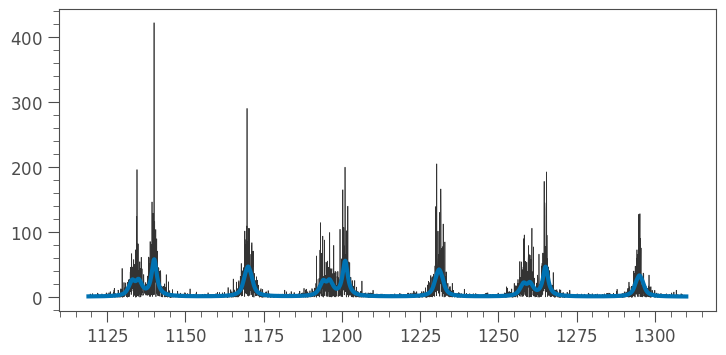

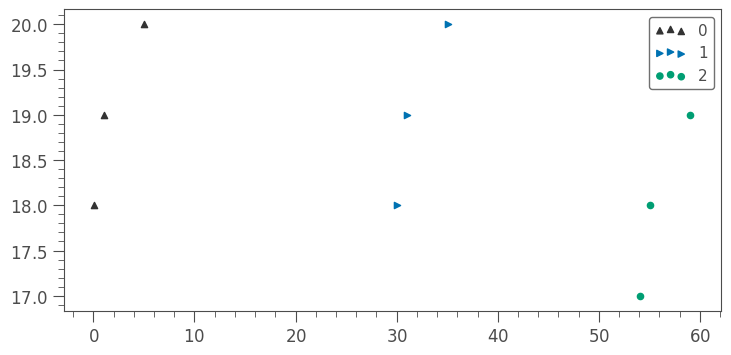

In [17]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0', s=20)
    ax.scatter(f1_%deltanu_, n1_, marker='>',label='1', s=20)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2', s=20)

    ax.legend()
    plt.show()    

## First lets fit the mode frequencies...

In [20]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax   = BNormal('numax',   mu=numax_,   sigma=100.,  testval=numax_)
    deltanu = BNormal('deltanu', mu=deltanu_, sigma=10.,  testval=deltanu_)
    alpha   = BNormal('alpha',   mu=alpha_,   sigma=0.001,  testval=alpha_)
    epsilon = BNormal('epsilon', mu=epsilon_, sigma=0.01,   testval=epsilon_)
    d01     = BNormal('d01',     mu=d01_,     sigma=5., testval=d01_)
    d02     = BNormal('d02',     mu=d02_,     sigma=1.,  testval=d02_)
    
    f0 = pm.Deterministic('f0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]))
    f1 = pm.Deterministic('f1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]))
    f2 = pm.Deterministic('f2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]))
    
    like0 = pm.Normal('like0', mu=f0, sigma=1., observed=f0_)
    like1 = pm.Normal('lik10', mu=f1, sigma=1., observed=f1_)
    like2 = pm.Normal('lik20', mu=f2, sigma=1., observed=f2_)    
    
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [d02, d01, epsilon, alpha, deltanu, numax]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:15<00:00, 265.00draws/s]


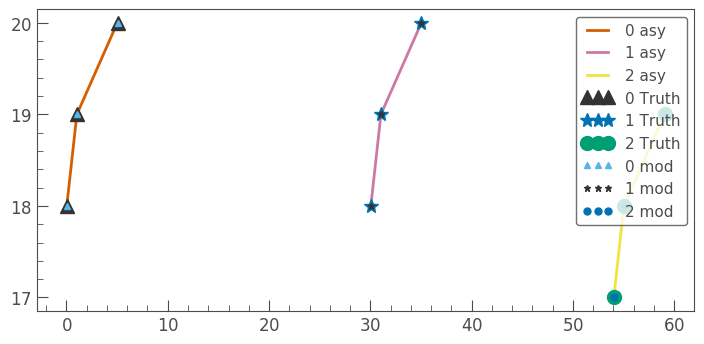

In [27]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
    

    
    ax.errorbar(f0_%res[1], n0_, fmt='^',label='0 Truth', capsize=5, markersize=10)
    ax.errorbar(f1_%res[1], n1_, fmt='*',label='1 Truth', capsize=5, markersize=10)
    ax.errorbar(f2_%res[1], n2_, fmt='o',label='2 Truth', capsize=5, markersize=10)   
    
    ax.plot(mod.f0(res)%res[1], n0_, label='0 asy',lw=2)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 asy',lw=2)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 asy',lw=2)
    
    ax.errorbar(resls[0]%res[1], n0_, fmt='^',label='0 mod', capsize=5, markersize=5)
    ax.errorbar(resls[1]%res[1], n1_, fmt='*',label='1 mod', capsize=5, markersize=5)
    ax.errorbar(resls[2]%res[1], n2_, fmt='o',label='2 mod', capsize=5, markersize=5)    
    
    ax.legend(loc='best')    

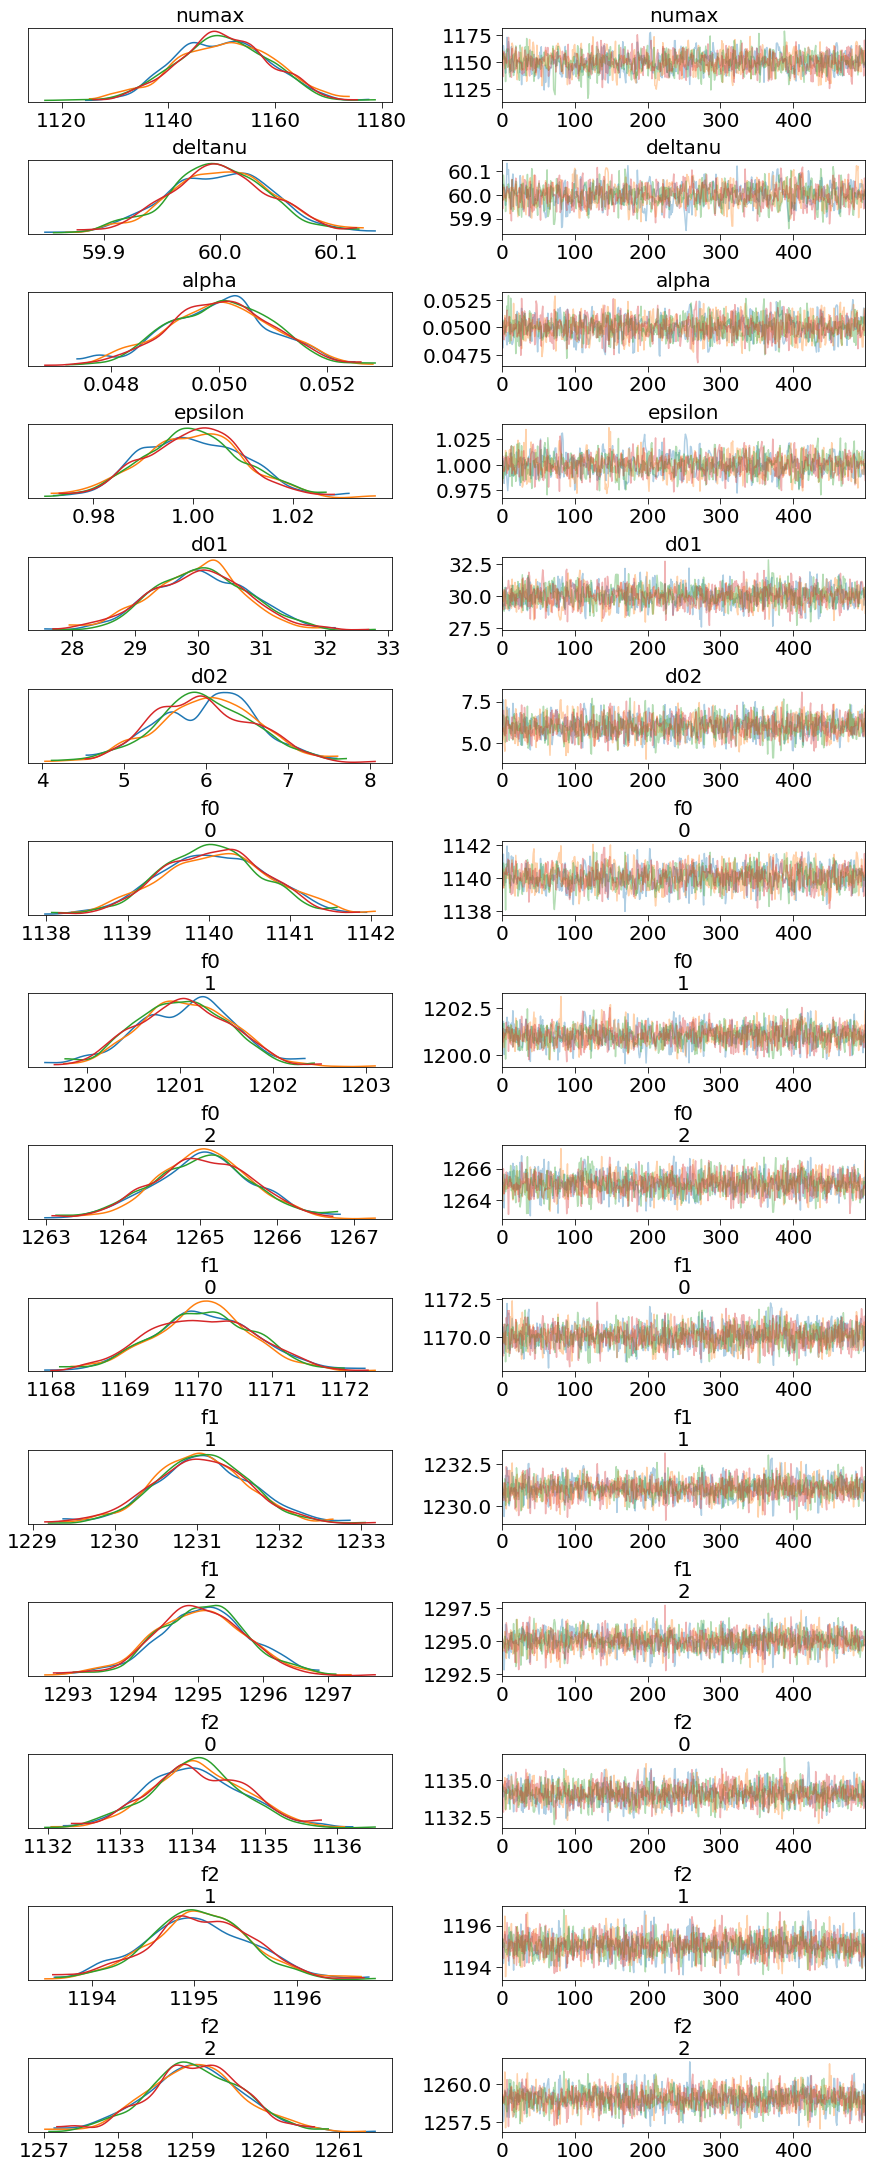

In [22]:
pm.traceplot(trace);

# Now lets try and fit this

In [17]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    f0 = pm.Normal('f0', mu=f0_, sigma=10., testval=f0_, shape=(len(f0_)))
    f1 = pm.Normal('f1', mu=f1_, sigma=10., testval=f1_, shape=(len(f1_)))
    f2 = pm.Normal('f2', mu=f2_, sigma=10., testval=f2_, shape=(len(f2_)))

    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [18]:
with pm_model:
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, a2, a1, a0, g2, g1, g0, f2, f1, f0]
Sampling 4 chains: 100%|██████████| 4000/4000 [01:55<00:00, 34.75draws/s]


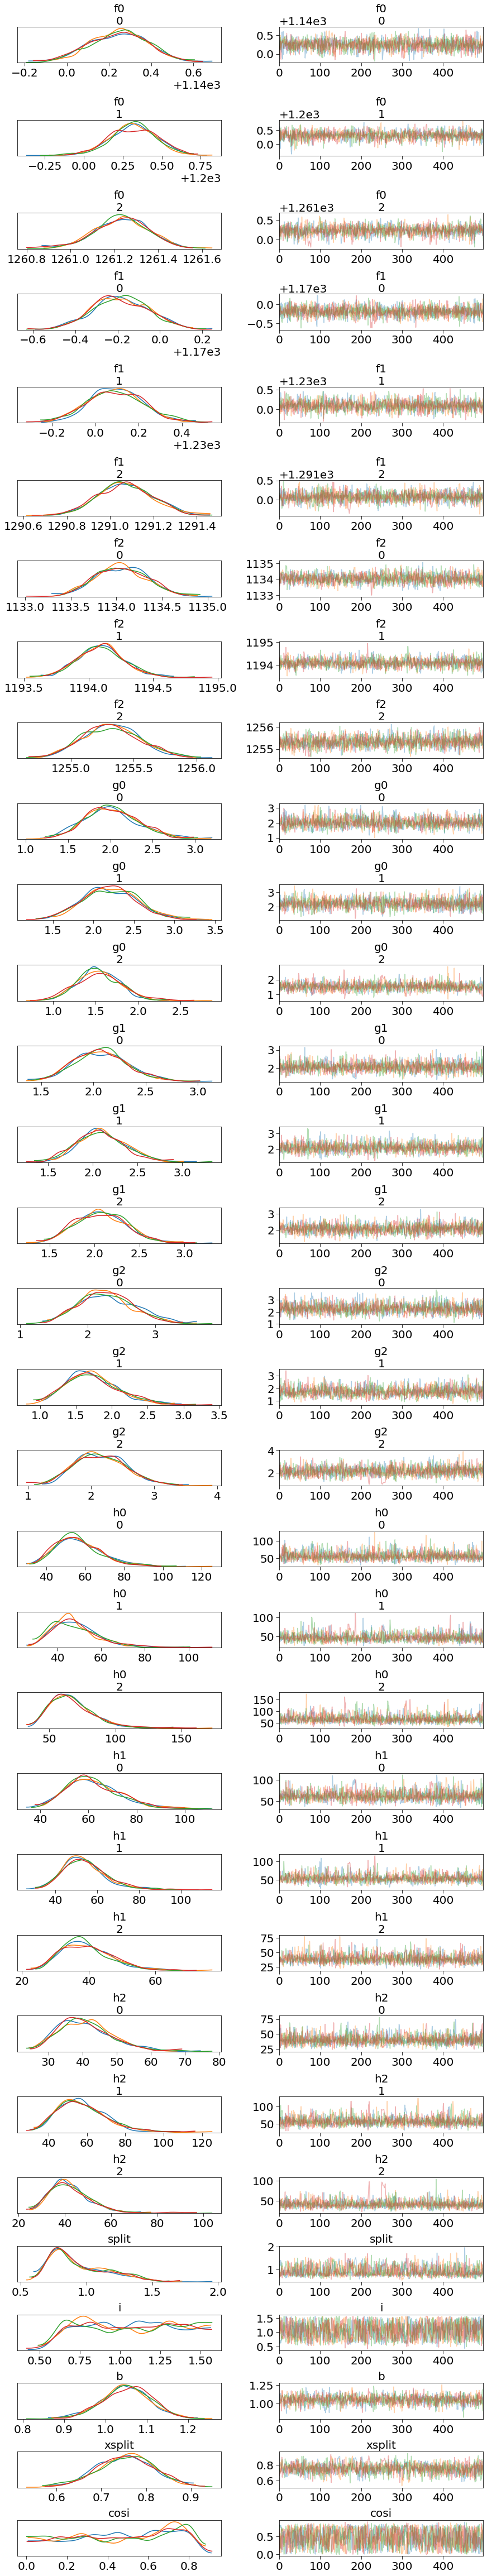

In [19]:
pm.traceplot(trace, var_names = ['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i','b','xsplit','cosi'])
plt.show()

In [20]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
f0__0,1140.244807,0.140261,0.002943,1139.977160,1140.521612,2019.042327,0.999784
f0__1,1200.313196,0.152633,0.003744,1200.022155,1200.623086,1548.550265,0.999796
f0__2,1261.230880,0.124720,0.002971,1260.987566,1261.480779,1742.210757,0.999846
f1__0,1169.812858,0.132709,0.002805,1169.568496,1170.078502,2334.218660,0.999536
f1__1,1230.092633,0.129029,0.002691,1229.840907,1230.352277,1993.463070,0.999831
f1__2,1291.068992,0.128722,0.003204,1290.820128,1291.317620,1720.122590,0.999502
f2__0,1134.049276,0.286589,0.008110,1133.493880,1134.584651,1475.888564,0.999653
f2__1,1194.095040,0.181595,0.004370,1193.724653,1194.443892,1980.234273,0.999275
f2__2,1255.321086,0.233271,0.005636,1254.876367,1255.785290,1600.339771,0.999628
g0__0,2.017549,0.326525,0.008247,1.376884,2.645133,1845.267137,0.999380


# Now lets plot some diagnostics...

In [21]:
labels=['xsplit','cosi','split','i','b',
'numax','deltanu','epsilon','d01','d02']
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$\delta\nu_{\rm s}$', r'$i$','b',
          r'$\nu_{\rm max}$',r'$\Delta\nu$',r'$\epsilon$',r'$\delta\nu_{01}$',r'$\delta\nu_{02}$']

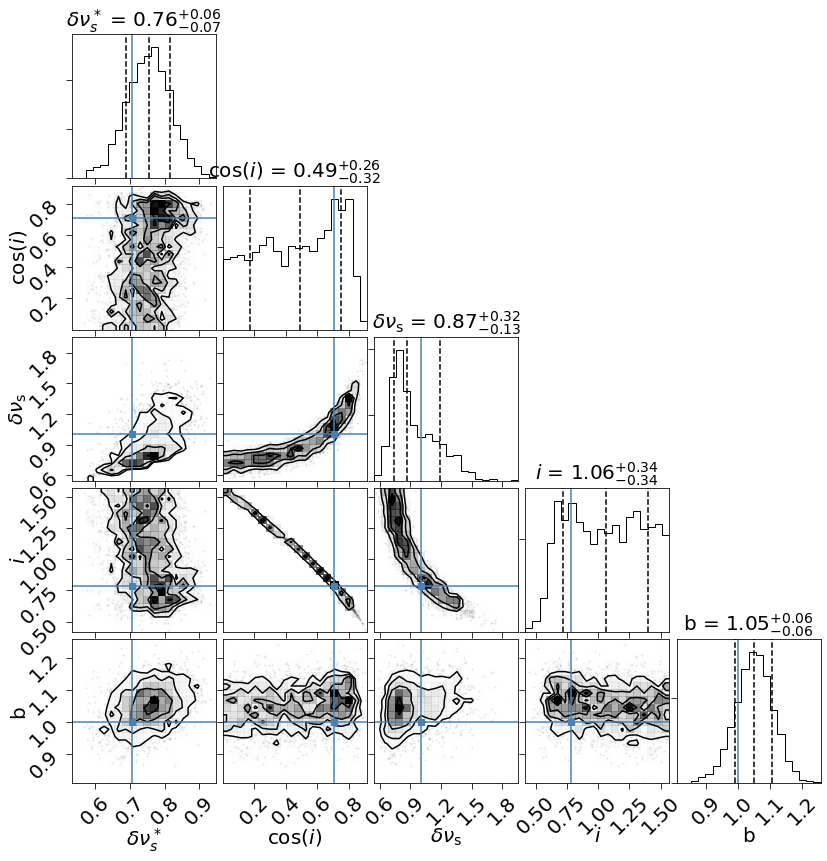

In [25]:
truths = [init_m[9] * np.sin(init_m[10]), np.cos(init_m[10]), init_m[9], init_m[10], 1.,
          numax_, deltanu_, epsilon_, d01_, d02_]
chain = np.array([trace[label] for label in labels[:5]])

corner.corner(chain.T, labels=verbose[:5], quantiles=[0.16, 0.5, 0.84]
              ,truths=truths[:5], show_titles=True)
plt.show()

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots(2, figsize=(8.75, 8), sharex=True )
    ax[0].plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
    res = np.array([np.median(trace[label],axis=0) for label in labels])    
    ax[0].plot(f, mod.model(res, theano=False), lw=2)

    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
    
    ax[1].plot(mod.f0(res), n0_, label='0 asy',lw=2)
    ax[1].plot(mod.f1(res), n1_, label='1 asy',lw=2)
    ax[1].plot(mod.f2(res), n2_, label='2 asy',lw=2)
    
    ax[1].errorbar(resls[0], n0_, fmt='^',label='0 mod', capsize=5, markersize=5)
    ax[1].errorbar(resls[1], n1_, fmt='*',label='1 mod', capsize=5, markersize=5)
    ax[1].errorbar(resls[2], n2_, fmt='o',label='2 mod', capsize=5, markersize=5)
    
    ax[1].errorbar(f0_, n0_, fmt='^',label='0 Truth', capsize=5, markersize=5)
    ax[1].errorbar(f1_, n1_, fmt='*',label='1 Truth', capsize=5, markersize=5)
    ax[1].errorbar(f2_, n2_, fmt='o',label='2 Truth', capsize=5, markersize=5)    
    
    ax[1].legend(loc='best')    
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
    
    ax.plot(mod.f0(res)%res[1], n0_, label='0 asy',lw=2)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 asy',lw=2)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 asy',lw=2)
    
    ax.errorbar(resls[0]%res[1], n0_, fmt='^',label='0 mod', capsize=5, markersize=5)
    ax.errorbar(resls[1]%res[1], n1_, fmt='*',label='1 mod', capsize=5, markersize=5)
    ax.errorbar(resls[2]%res[1], n2_, fmt='o',label='2 mod', capsize=5, markersize=5)
    
    ax.errorbar(f0_%res[1], n0_, fmt='^',label='0 Truth', capsize=5, markersize=5)
    ax.errorbar(f1_%res[1], n1_, fmt='*',label='1 Truth', capsize=5, markersize=5)
    ax.errorbar(f2_%res[1], n2_, fmt='o',label='2 Truth', capsize=5, markersize=5)    
    
    ax.legend(loc='best')    
    
    

In [ ]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

In [ ]:
labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
res = np.array([np.median(trace[label],axis=0) for label in labels])  
residual = p/mod.model(res, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()